In [4]:
pip install --upgrade transformers

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install --upgrade pyfunctional

  Using cached PyFunctional-1.4.3-py3-none-any.whl (49 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
%%capture
%run "context_learning_nrk.ipynb"

In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import sys
import os

os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from itertools import chain
import math
from functools import reduce
import numpy as np 
# np.set_printoptions(threshold=np.inf)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from transformers.trainer_utils import EvaluationStrategy


In file_utils.py: default_cache_path = /raid/xd/.cache/torch/transformers


In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM, GPTJForCausalLM

In [4]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _
from collections import namedtuple 

In [5]:
l = [('a', 1), ('b', 2), ('a', 3), ('c', 2)]

In [6]:
seq(l).dom()

['a', 'b', 'c']

In [7]:
seq(l).codom()

[1, 2, 3]

In [14]:
seq(l).image('a')

[1, 3]

In [11]:
seq(l).image(['a', 'c'])

[1, 3, 2]

In [13]:
seq(l).preimage([3, 2])

['b', 'a', 'c']

In [5]:
from utils import *
from child_utils import *
from common_utils import *

In [6]:
import random

In [7]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
proxies = {'http': '192.168.50.1:1081'} 

In [1580]:
model_name = "EleutherAI/gpt-j-6B"
# model_name = "EleutherAI/gpt-neo-1.3B"
model = GPTJForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
# model = GPTNeoForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
models[model_name] = model, tokenizer

loading configuration file https://huggingface.co/EleutherAI/gpt-j-6B/resolve/main/config.json from cache at /nas/xd/.cache/torch/transformers/gpt-j-6B-config.json
Model config GPTJConfig {
  "activation_function": "gelu_new",
  "architectures": [
    "GPTJForCausalLM"
  ],
  "attn_pdrop": 0.0,
  "bos_token_id": 50256,
  "embd_pdrop": 0.0,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gptj",
  "n_embd": 4096,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 28,
  "n_positions": 2048,
  "resid_pdrop": 0.0,
  "rotary": true,
  "rotary_dim": 64,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50,
      "temperature": 1.0
    }
  },
  "tie_word_embeddings": false,
  "tok

In [1590]:
prompt_token = 'Ġ!'; prompt_id = tokenizer._convert_token_to_id(prompt_token)
bop_str = 'Instruction: '; bop_id = tokenizer.encode(bop_str)[0]  # 'Inst'
eop_str = '. For example:'; eop_id = tokenizer.encode(eop_str)[2] # 'Ġexample'
bos_id = tokenizer._convert_token_to_id('Ġ->')
eos_id = tokenizer._convert_token_to_id('Ċ')


class CHILDDataset(Dataset):
    def __init__(self, input_strs, tokenizer):
        if tokenizer.pad_token is None: tokenizer.pad_token = '!'
        self.inputs = tokenizer.batch_encode_plus(input_strs, add_special_tokens=False, padding=True, return_tensors='pt')#长的截，短的补
        input_ids = self.inputs.input_ids
        self.labels = torch.ones_like(input_ids) * (-100)

        for bi in range(input_ids.size(0)): 
            bop_idx = (input_ids[bi] == bop_id).nonzero().squeeze(1) #prompt
            eop_idx = (input_ids[bi] == eop_id).nonzero().squeeze(1) #context

            if len(bop_idx) > 0:
                assert len(bop_idx) == 1 and len(eop_idx) == 1
                bop_idx, eop_idx = bop_idx.item(), eop_idx.item() #取出单元素张量的元素值并返回该值，保持原元素类型不变
                #bop: 0   eop:6
                input_ids[bi, bop_idx: eop_idx + 2] *= -1  # use prompt embedding for prompt tokens
  
            bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
#             print("bos_indices:",bos_indices)
            eos_indices = (input_ids[bi] == eos_id).nonzero()[-len(bos_indices):].squeeze(1) #每一位 eos都比bos大2
#             print("eos_indices:",eos_indices)
            for i, (bos_i, eos_i) in enumerate(zip(bos_indices.tolist(), eos_indices.tolist())):
                assert eos_i > bos_i + 1
                if i >= 3:  #zero-shot
                    self.labels[bi, bos_i + 1: eos_i] = input_ids[bi, bos_i + 1: eos_i] 
        
        
    def re_input(self):
        return self.inputs['input_ids']
        
    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, i):
        return {'input_ids': self.inputs['input_ids'][i],  #输入
                'attention_mask': self.inputs['attention_mask'][i],
                'labels': self.labels[i]}   #结果

In [609]:
print(train_dataset[0])

{'input_ids': tensor([ -6310,  -2762,    -25, -39771,  -1022,   -734,  -5621,    -13,  -1114,
         -1672,    -25,    198,  40245,     25,    256,   2178,   1754,     11,
          9925,     25,    356,  25011,     72,     11,   4422,     25,    356,
         25011,     72,     11,  23040,     25,    256,   2178,   1754,     13,
         17635,   6510,    423,  14958,     13,    685,    439,   1220,    617,
          1220,   4844,     60,     30,   4613,    477,    198,      0,      0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0]), 'labels': tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100

In [9]:
bos_id,eos_id

(4613, 198)

In [16]:
from child_utils import *
torch.set_printoptions(threshold=np.inf)

In [607]:
class WrappedEmbedding(nn.Module):
    def __init__(self,  
                wte: nn.Embedding,  #正常向量
                prompt_id: int = None,
                prompt_len: int = 10, 
                random_range: float = 0.5,
                initialize_from_vocab: bool = True):
        super(WrappedEmbedding, self).__init__()
#         self.wte = wte
#         self.prompt_id = prompt_id
#         self.prompt_len = prompt_len
        self.__dict__.update(locals()); del self.self #locals()以字典类型返回当前位置的全部局部变量
        if self.prompt_id is not None: #prompt_embedding prompt词向量
            self.prompt_embedding = nn.parameter.Parameter( #将一个不可训练的类型Tensor转换成可以训练的类型parameter
                self.initialize_embedding(random_range, initialize_from_vocab)).to(self.wte.weight.device) #在-0.5-0.5中随机取值初始化
        else:
            self.prompt_embedding = nn.Embedding(self.prompt_len, self.wte.weight.size(1)).to(self.wte.weight.device)
                                        #词典大小（总共输入多少词） 嵌入向量维度（多少维表示一个符号）
            
            assert initialize_from_vocab
            self.init_prompt_embedding_()  #将wte的weight值作为初始化
#             self.prompt_embedding.weight.data = self.initialize_embedding(random_range, initialize_from_vocab)     
 
    def initialize_embedding(self, random_range: float = 0.5, initialize_from_vocab: bool = True):
        if initialize_from_vocab: return self.wte.weight[:self.prompt_len].clone().detach() #返回一个新的tensor，新的tensor和原来的tensor共享数据内存，但不涉及梯度计算
        return torch.FloatTensor(self.prompt_len, self.wte.weight.size(1)).uniform_(-random_range, random_range) #产生随机数
    
    def init_prompt_embedding_(self):
#         print(self.wte.weight)
        self.prompt_embedding.weight.data[:] = self.wte.weight[:self.prompt_len]

        
    def forward(self, input_ids):
        if self.prompt_id is not None:
            input_embeds = self.wte(input_ids)
            input_embeds[input_ids == self.prompt_id] = self.prompt_embedding.expand(input_embeds.size(0), -1, -1)
        else: # adapted from cpm-2
            prompt_mask = input_ids < 0  #返回bool类型
#             print("prompt_mask:",prompt_mask.shape)
            prompt_ids = -input_ids * prompt_mask #将prompt的值变为正数，其他置零
#             print("prompt_ids:",prompt_ids)
#             print(prompt_ids < self.prompt_len)
#             print(prompt_ids)
            assert torch.all(prompt_ids < self.prompt_len)
#             print(self.prompt_embedding(prompt_ids).shape)
            p_embeds = self.prompt_embedding(prompt_ids) * prompt_mask.float().unsqueeze(-1)
#             print("p_embeds:",p_embeds.shape)
            input_ids = input_ids * ~prompt_mask
            w_embeds = self.wte(input_ids) * (~prompt_mask).float().unsqueeze(-1)
#             print("w_embeds:",w_embeds.shape)
            input_embeds = w_embeds + p_embeds 
#         print(input_embeds)
        return input_embeds

In [593]:
# adapted from cpm-2: https://github.com/TsinghuaAI/CPM-2-Finetune/blob/master/utils.py#L133-L164
def get_params_for_prompt_optimization(module: nn.Module): #不训练模型参数，只训练prompt_embading，这个函数是取这些参数
    params = []
    for t in module.named_modules():
        if "prompt_embedding" in t[0]:
            params.append({'params': [p for p in list(t[1]._parameters.values()) if p is not None]})
    for t in module.named_parameters():
        if "prompt" not in t[0]:
            t[1].requires_grad_(False)    
    return params

def create_optimizer(model, training_args):
    from torch.nn.parallel.distributed import DistributedDataParallel as DDP
    while isinstance(model, (DDP, )): model = model.module
        
    we.init_prompt_embedding_()
    param_groups = get_params_for_prompt_optimization(model)
    optimizer = AdamW(param_groups, lr=training_args.learning_rate, 
                      betas=(training_args.adam_beta1, training_args.adam_beta2),eps=training_args.adam_epsilon)
    return optimizer

In [678]:
# wte = model.get_input_embeddings() #提取 embedding 中的 词向量部分
# if hasattr(wte, 'wte'): wte = wte.wte  # already been wrapped
# we = WrappedEmbedding(wte, prompt_len=20000)
# model.set_input_embeddings(we) #为词向量赋值

In [13]:
def verbalize(obj):
    if type(obj) == bool: return 'Yes' if obj else 'No'
    return str(obj)

def list2str(l): return ' '.join(str(i) for i in l)
def pairs2str(pairs): return ', '.join(str(k) + ': ' + str(v) for k, v in pairs)

def make_context_str(cxt):
    if type(cxt) == list:
        return pairs2str(cxt) if type(cxt[0]) == tuple and len(cxt[0]) == 2 else list2str(cxt)
    if type(cxt) == tuple:
        return '; '.join(make_context_str(c) for c in cxt)  # 用分号分隔context的不同部分
    
def make_query_str(instruction, query):
    if instruction is None and query is None: return ''
    s = '.'
    if instruction is not None: s = s + ' ' + instruction
    if query is not None:
        if type(query) in [int, bool, str]: query = [query]
        if type(query) == dict:# and list(query.keys())[0] != "CS"):  # by nrk
            s = s + ' ' + '{' + ','.join([' replace %s with %s' % (str(k), str(v)) for k, v in query.items()]) + ' }'
        if type(query) in [list, tuple]:
            s = s + ' ' + ' '.join([list2str(i) if type(i) == list else str(i) for i in query])
    return s

def make_example_str(example, query2str):
    instruction, cxt, query, ans = example
    if type(ans) not in [Sequence, list]: ans = [ans]
    ans = [verbalize(a) for a in ans]
#     return '%s -> %s' % (''.join(l[0]) + make_query_str(instruction if with_instruction else None, query), ' '.join(ans))  # by nrk
#     return '%s -> %s' % (' '.join(l) + make_query_str(instruction if with_instruction else None, query), ' '.join(ans))  # by XD
#     return '%s -> %s' % (make_context_str(cxt) + make_query_str(instruction if with_instruction else None, query[0]), ' '.join(ans))
    return '%s -> %s' % (make_context_str(cxt) + query2str(query), ' '.join(ans))


def sample_rand_len(vocab, k): return sample(vocab, k=randint(1, k))

In [1015]:
def promptize(s):
#     return prompt_token * len(s.split())
    return bop_str + s + eop_str

courses_vocab=["Sql","Math","English","Chinese","Art","Music","History","Biology","Chemistry","Physics","Geography"]
all_vocab = ["apple","pear","peach","grape","banana","pineapple","lemon","strawberry","cola","juice","coffee","milk","wine","beer","whisky","vodka","brandy"]
solid_vocab=["apple","pear","peach","grape","banana","pineapple","lemon","strawberry"]
liquid_vocab=["cola","juice","coffee","milk","wine","beer","whisky","vodka","brandy"]
names_vocab =  [i for i in string.ascii_uppercase]
depts_vocab = ["CS","Chi","Eng","Mat"]
sl = ["solid"]*len(solid_vocab)+["liquid"]*len(liquid_vocab)
sl_vocab = dict(zip(all_vocab,sl))
toys = ["ball","doll","puppet","weiqi","chess","slide","diabolo","plasticine","tumbler"]
                                              #滑梯     空竹      橡皮泥      不倒翁
boys = ["Alex","Dylan","Daniel","Patrick","Austin","Harrison","Tom","Neil"]
girls = ["Ashley","jessica","Sarah","Amanda","Nicole","Katherine","Anne","Eva"]
all = boys+girls
bg = ["boys"]*len(boys)+["girls"]*len(girls)
bg_vocab = dict(zip(all,bg))

all = solid_vocab+toys
ft = ["fruits"]*len(solid_vocab)+["toys"]*len(toys)
ft_vocab = dict(zip(all,ft))

def make_input_str(task, nrows=4, ncols=4, full_vocab=None, ans_vocab=[True, False]):
    if full_vocab is None: full_vocab = string.ascii_uppercase + string.digits
    transform_fn, vocab_fn, sample_fn, query_fn, query2str = task
    instruction = transform_fn.__name__.replace('_', ' ')
    if vocab_fn is None: vocab_fn = lambda: full_vocab
    if query_fn is None: query_fn = lambda *_: None
        
    examples = []
    query = None
    for i in range(nrows):
        vocab = vocab_fn()
        l = sample_fn(vocab, k=ncols)
        query = query_fn(l, vocab, ncols)
        examples.append([instruction, l, query, transform_fn(l, query=query)])
    examples = balance(examples,ans_vocab)

    desc = promptize(instruction) if True else ''
    text = '\n'.join([make_example_str(e, query2str) for e in examples])
    text = desc + '\n' + text + '\n'
    return text

In [17]:
# # def balance(examples, ans_vocab=[True, False]):
# def balance1(examples, ans_vocab):
#     groups = seq(examples).group_by(_[-1]).map(_[1])  # 按ans分组
# #     assert groups.len() == len(ans_vocab), '%d < %d' % (groups.len(), len(ans_vocab))  # 保证每种ans都出现
#     min_cnt = groups.map(lambda x: len(x)).min()
#     examples = groups.map(lambda x: sample(x, min_cnt)).flatten().list() # 每组都采样最小个数后去分组
#     return sample(examples, len(examples))  # 重新打乱

In [1591]:
def balance(examples, ans_vocab):
    groups = seq(examples).group_by(_[-1]).map(_[1])  # 按ans分组
#     min_cnt = groups.map(lambda x: len(x)).min()
    min_cnt = 2
    if(groups.len()>3):
        min_cnt = 2
    elif(groups.len()==3):
        min_cnt = 2
    if(min_cnt > 2):
        examples = groups.map(lambda x: sample(x, 2)).flatten().list() # 每组都采样最小个数后去分组
        return sample(examples, len(examples))  # 重新打乱
    else:
        examples = groups.map(lambda x: sample(x, min_cnt)).flatten().list() # 每组都采样最小个数后去分组
        return sample(examples, len(examples))  # 重新打乱

In [1373]:
import itertools  
def Do_all_students_choose_courses_in_a_department(cxt, query):
    SC, CD = cxt  # SC paris: studeng-course relation, CD pairs: course-department function
    ss, d = query  # ss: 学生子集（可以*不止两个学生*），d: 课程
#     return seq(ss).map(lambda s: seq(SC).filter(_[0] == s).map(_[1]).intersection(CD.filter(_.[1] == d).map(_.[0])).non_empty()).all()
    return (seq(ss)
            .map(lambda s: seq(SC).filter(_[0] == s).map(_[1])  # 学生s选的所有课程
                 .intersection(
                     seq(CD).filter(_[1] == d).map(_[0])) # d系的课程
                 .non_empty())  # s选了d系的课程
            .all())  # 学生子集ss都选了d系的课程

def all_a_sample(vocab, k):
    S_vocab, C_vocab, D_vocab = vocab  # vocabs of students, courses, departments
    k_S, k_C, k_D, k_SC = k  # default values: k_S = 3, k_C = 3, k_D = 2, k_SC = 5
    S, C, D = sample(S_vocab, k_S), sample(C_vocab, k_C), sample(D_vocab, k_D)
    
    while len(set(CD := choices(D, k=k_C))) < k_D: continue  # ds里每个系的课都要出现
    CD = list(zip(C, CD))  # 得到每门课所属的系
    
    all_SC = list(itertools.product(S, C))  # or seq(S).cartesian(C).list()
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue  # ss里每个学生都要选课
    return SC, CD

def select_distinct(tuples, col): return seq(tuples).map(_[col]).distinct().list()
    
def all_a_query(cxt,vocab,k):
    SC, CD = cxt
    k_S, k_C, k_D, k_SC = k
    S, D = select_distinct(SC, 0), select_distinct(CD, 1)
#     k_ss = randint(2, len(S))
    ss = sample(S, 2)
    d = choice(D)
    return ss, d

def all_a_query2str(query):
    ss, d = query
    query_str = '%s,%s?' % (', '.join(ss[:-1]) + ' and ' + ss[-1], d)
    return '. ' + query_str


In [1359]:
def all_b(cxt, query):
    SC, CD = cxt
    ss,d = query
    return (seq(CD).filter(_[1] == d).map(_[0])
                 .difference(
                     seq(SC).filter(_[0] == ss).map(_[1]))
                 .empty())

def all_b_sample(vocab, k):
    S_vocab, C_vocab, D_vocab = vocab  
    k_S, k_C, k_D, k_SC = k  # default values: k_S = 2, k_C = 3, k_D = 2, k_SC = 5
    S, C, D = sample(S_vocab, k_S), sample(C_vocab, k_C), sample(D_vocab, k_D)
    
    while len(set(CD := choices(D, k=k_C))) < k_D: continue  
    CD = list(zip(C, CD)) 
    
    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue  # ss里每个学生都要选课
    return SC, CD
   
def all_b_query(cxt,vocab,k):  # XD: 不要给qeury_fn加st参数
    SC, CD = cxt
    k_S, k_C, k_D, k_SC = k
    S, D = select_distinct(SC, 0), select_distinct(CD, 1)
#     k_ss = randint(2, len(S))  # XD: k_ss unused
    ss = choice(S)
    d = choice(D)
    return ss, d
    # XD: 不要在query_fn里转str！！这里转str，transform_fn里再解析回来，两边不是白折腾吗！

def all_b_query2str(query):
    ss, d = query
    query_str = 'Does %s take all %s courses?' % (ss, d)
    return '. ' + query_str


def Is_the_intersection_of_two_sets_empty(cxt, query):
    SC= cxt
    s,d = query
    return (seq(SC).filter(_[0] == s).map(_[1])
                 .intersection(
                     seq(SC).filter(_[0] == d).map(_[1]))
                 .non_empty())

def intersection_query(cxt,vocab,k):
    SC= cxt
    k_S, k_C, k_SC = k #k_s = 3, k_C = 5 , k_sc = 6
    S = select_distinct(SC, 0)
    s,d = sample(S,2)
    return s, d

def intersection_query2str(query):
    s, d = query
    query_str = "%s,%s?" % (s, d)
    return '. ' + query_str

def intersection_sample(vocab, k):
    S_vocab, C_vocab = vocab  
    k_S, k_C, k_SC = k  # k_S = 3, k_C = 5, , k_SC = 6
    S, C= sample(S_vocab, k_S), sample(C_vocab, k_C)
    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue 
    return SC

def Is_the_first_set_a_subset_of_the_second_one(cxt, query):
    SC= cxt
    s,d = query
    return (seq(SC).filter(_[0] == d).map(_[1])
                 .union(
                     seq(SC).filter(_[0] == s).map(_[1]))
                 ).distinct().len()== seq(SC).filter(_[0] == d).map(_[1]).distinct().len()

def complement_query(cxt,vocab,k):
    SC= cxt
    k_S, k_C, k_SC = k #k_s = 3, k_C = 5 , k_sc = 6
    S = select_distinct(SC, 0)
    s,d = sample(S,2)
    return s, d

def complement_query2str(query):
    s, d = query
    query_str = "%s,%s?" % (s, d)
    return '. ' + query_str

def complement_sample(vocab, k):
    S_vocab, C_vocab = vocab  
    k_S, k_C, k_SC = k  # k_S = 3, k_C = 4, k_SC = 5
    S, C= sample(S_vocab, k_S), sample(C_vocab, k_C)
    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue 
    return SC

def Are_they_the_union_of_the_last_element(cxt, query):
    SC, DC = cxt
    ss,d = query
    return (seq(ss)
            .map(lambda s: seq(SC).filter(_[0] == s).map(_[1]) 
                 .union(
                     seq(DC).filter(_[0] == d).map(_[1])) 
                 .distinct().len() == seq(DC).filter(_[0] == d).map(_[1]).distinct().len())  
            .all()) 

def union_sample(vocab, k):
    S_vocab, C_vocab, D_vocab = vocab  
    k_S, k_C, k_D, k_SC = k  # k_S = 3, k_C = 4, k_D = 2, k_SC = 6
    S, C, D = sample(S_vocab, k_S), sample(C_vocab, k_C), sample(D_vocab, k_D)
    
    while len(set(DC := choices(D, k=k_C))) < k_D: continue  
    DC = list(zip(DC,C)) 
    
    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue  
    return SC, DC
   
def union_query(cxt,vocab,k): 
    SC, DC = cxt
    k_S, k_C, k_D, k_SC = k
    S, D = select_distinct(SC, 0), select_distinct(DC, 0)
    k_ss = randint(2, len(S))
    ss = sample(S, k_ss)
    d = choice(D)
    return ss, d

def union_query2str(query):
    ss, d = query
    query_str = '%s,%s?' % (', '.join(ss[:-1]) + ' and ' + ss[-1], d)
    return '. ' + query_str

def Are_there_elements_belonging_to_the_same_class(cxt, query): #新建联系，把vocab和属性连起来形成新集合
    NA, DA = cxt
    s,d = query
    D = seq(DA).filter(_[0] == d).map(_[1])
    return (seq(NA).filter(_[0] == s).map(_[1]).select(lambda x: sl_vocab[x] == sl_vocab[D[0]]).any())
      
    
def find_sample(vocab, k): 
    name_vocab, all_vocab = vocab
    k_name, k_all, k_D, k_SA = k  # k_name = 3, k_all = 4, k_D = 2, k_SA = 6
    S = list(all_vocab.keys())
    N, A, D = sample(name_vocab, k_name), sample(S, k_all), sample(string.ascii_lowercase, k_D)
#     D = sample(d := name_vocab.pop(name_vocab.index(a) for a in N),k_D)
    A1 = sample(S, k_D)
    DA = list(zip(D,A1)) 
    
    all_NA = list(itertools.product(N, A))  
    while seq(NA := sample(all_NA, k_SA)).map(_[0]).distinct().len() < k_name: continue  
    return NA, DA
   
def find_query(cxt,vocab,k): 
    NA, DA = cxt
    k_name, k_all, k_D, k_SA = k
    S,D = select_distinct(NA, 0), select_distinct(DA, 0)
    s,d = choice(S), choice(D)
    return s, d

def find_query2str(query):
    s, d = query
    query_str = '%s,%s?' % (s, d)
    return '. ' + query_str


def Are_there_any_elements_different_from_other_elements(cxt, query):
    NA = cxt
    ss = query
    return (seq(ss).map(lambda s: seq(NA).filter(_[0] == s).map(_[1])
                        .select(lambda x: sl_vocab[x])[0])
            .distinct().len( ) == 2)
               
def find_dif_sample(vocab, k):
    name_vocab, all_vocab = vocab
    k_name, k_all, k_SA = k  # k_name = 4, k_all = 4, k_SA= 3
    N, A = sample(name_vocab, k_name), sample(list(all_vocab.keys()), k_all) 
    NA = list(zip(N,A)) 
    return NA
   
def find_dif_query(cxt,vocab,k): 
    NA = cxt
    k_name, k_all, k_NA = k
    S = select_distinct(NA, 0)
    ss = sample(S,k_NA)
    return ss


def find_dif_query2str(query):
    ss = query
    query_str = '%s?' % (', '.join(ss[:-1]) + ' and ' + ss[-1])
    return '. ' + query_str



In [1360]:
def How_many_elements_are_similar_to_the_case(cxt, query):
    s = cxt
    q = query
    return seq(s).filter(lambda x: sl_vocab[x] == sl_vocab[q[0]]).len()
                     
def count_sample(vocab, k):
    all_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 4 ,k_query =1
    N = list(all_vocab.keys())
    s = sample(N, k_cxt) 
    return s
   
def count_query(cxt,vocab,k): 
    NA = cxt
    k_cxt,k_query = k
    N = list(vocab.keys())
    q = sample(N,k_query)
    return q

def count_query2str(query):
    q = query
    query_str = '%s?' % (q[0])
    return '. ' + query_str

def Is_the_number_of_first_elements_greater_than_the_second_one(cxt, query):
    s = cxt
    q = query
    return (seq(s).filter(lambda x: sl_vocab[x] == sl_vocab[q[0]]).len() >= len(s)/2)
                     
def compare_sample(vocab, k):
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 5 ,k_query =2
    N = list(all_vocab.keys())
    s = sample(N, k_cxt) 
    return s
   
def compare_query(cxt,vocab,k): 
    NA = cxt
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k
    q = sample(s_vocab,1)+sample(l_vocab,1)
    random.shuffle(q)
    return q

def compare_query2str(query):
    ss,q = query
    query_str = '%s,%s?' % (ss,q)
    return '. ' + query_str

In [1361]:
def Ascii_size_existence(l, query): return seq(l).map(_[0] > query).any()
def Ascii_size_all(l, query): return seq(l).map(_[0] > query).all()
def Ascii_size_None(l, query): return seq(l).filter(_[0] > query).empty()
def ith_element(l, query=None): return seq(l).slice(1, 2)
def ith_group(l, query=None): return seq(l).group_by(_).select(_[1]).slice(1, 2).flatten()#.distinct()# davinci F w/ and wo dist
# def element_at_index(l, query): return seq(l).slice(query, query + 1) # davinci F
def element_at_index(l, query): return seq(l).enumerate().filter(_[0] == query).select(_[1])
def replace(l, query): return seq(l).map(lambda x: query.get(x, x))
def replace_with_the_other(l, query): # davinci F
    query = {k: (set(l) - {k}).pop() for k in l}
    return replace(l, query)
def replace_all_with(l, query): return seq(l).map(lambda x: query)  # davinci F?!
def interleave_with(l, query): return seq(l).flat_map(lambda x: [x, query])  # davinci T!!
def unique_elements(l, query=None): return seq(l).distinct() # davinci F
def how_many_unique_elements(l, query=None): return seq(l).distinct().len()  # davinci F
def how_many(l, query): return seq(l).filter(_ == query).len() # davinci F
def select_same_as(l, query): return seq(l).filter(_ == query) # simpler version of how_many. davinci F
def select_same_number_as(l, query): return seq(l).group_by(_).select(_[1]).filter(lambda x: len(x) == len(query)).flatten() # F
def includes(l, query): return seq(l).union(seq(query)).distinct().len() == seq(l).distinct().len() # davinci F
def is_included_by(l, query): return seq(l).difference(seq(query)).empty() # davinci F

In [1362]:
def Compare_the_values_of_two_sets(cxt, query):
    s = cxt
    q = query
    if(seq(s).filter(lambda x: sl_vocab[x] == sl_vocab[q[0]]).len() > len(s)/2):
        return ">"
    elif(seq(s).filter(lambda x: sl_vocab[x] == sl_vocab[q[0]]).len() < len(s)/2):
        return "<"
    else:
        return "="

def Compare_sample(vocab, k):
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 5 ,k_query =2
    N = list(all_vocab.keys())
    s = sample(N, k_cxt) 
    return s
   
def Compare_query(cxt,vocab,k): 
    NA = cxt
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k
    q = sample(s_vocab,1)+sample(l_vocab,1)
    random.shuffle(q)
    return q

def Compare_query2str(query):
    ss,q = query
    query_str = '%s,%s?' % (ss,q)
    return '. ' + query_str

In [1363]:
def Relationship_between_two_sets(cxt, query): #新建联系，把vocab和属性连起来形成新集合
    NA = cxt
    s,q= query   #s:boys/girls  q:fruits/toys
    name = seq(NA).filter(lambda x: bg_vocab[x[0]] == s)
    if(seq(name).map(_[1]).filter(lambda x: ft_vocab[x] == q).len() == seq(name).len()):
        return "all"
    elif(seq(name).map(_[1]).filter(lambda x: ft_vocab[x] == q).empty()):
        return "none"
    else:
        return "some"
    
def Relationship_sample(vocab, k): 
    name_vocab, all_vocab = vocab
    k_name, k_all, k_SA = k  # k_name = 4, k_all = 4, k_SA = 4
    Name = list(name_vocab.keys())
    S = list(all_vocab.keys())
    N, A = sample(Name, k_name), sample(S, k_all)
#     D = sample(d := name_vocab.pop(name_vocab.index(a) for a in N),k_D)
    
    all_NA = list(itertools.product(N, A))  
    while seq(NA := sample(all_NA, k_SA)).map(_[0]).distinct().len() < k_name: continue  
    return NA
   
def Relationship_query(cxt,vocab,k): 
    NA = cxt
    name_vocab, all_vocab = vocab
    k_name, k_all, k_SA = k
    S,D = select_distinct(NA, 0),select_distinct(NA, 1)
    s,d = choice(S),choice(D)
    s1,d1 = name_vocab[s],all_vocab[d]
    return s1,d1

def Relationship_query2str(query):
    s,q = query
    query_str = '[] %s have %s. [all / some / none]?' % (s,q)
    return '. ' + query_str

In [1374]:
tasks = [
    (ith_element,            None,                               sample,    None,None),
    (ith_group,              None, lambda vocab, k: seq(sample(vocab, k)).map(lambda x:[x]*randint(1, 3)).flatten().list(),None,None),
    (element_at_index,       lambda: upper_letters,              sample,    lambda l,vocab,k: randint(0, min(2,len(l)-1))),
    (replace,                None,                               sample,    lambda l,vocab,k: {choice(l): choice(vocab)}),
    (replace_with_the_other, lambda: sample(full_vocab, 2),   lambda vocab,k: sample(vocab+choices(vocab, k=k-2),k), None),
    (replace_all_with,       None,                               sample_rand_len, lambda l,vocab,k: choice(vocab)),
    (interleave_with,        None,                               sample_rand_len, lambda l,vocab,k: choice(vocab)),
    (unique_elements,        lambda: sample(upper_letters, 3),   choices,   None),
    (how_many_unique_elements,lambda: sample(upper_letters, 3),  choices,   None),
    (how_many,               lambda: sample(upper_letters, 3),   choices,   lambda l,vocab,k: choice(list(set(l)))),
    (select_same_as,         lambda: sample(upper_letters, 3),   choices,   lambda l,vocab,k: choice(list(set(l)))),
    (select_same_number_as,  None, lambda vocab, k: seq(sample(vocab, k)).map(lambda x:[x]*randint(1, 3)).flatten().list(),   
     lambda l,vocab,k: [choice(vocab)]*randint(1, 3)),
    (includes,               lambda: sample(upper_letters, 6),   sample,    lambda l,vocab,k: sample(vocab, 3)),
    (is_included_by,         lambda: sample(upper_letters, 6),   sample,    lambda l,vocab,k: sample(vocab, 5)),
    
    (Ascii_size_None,        lambda: string.ascii_uppercase,              sample,    lambda l,vocab,k: "Is there no element greater than %s?" % choice(list(set(l)))),
    (Ascii_size_all,         lambda: string.ascii_uppercase,              sample,    lambda l,vocab,k: "Are all elements greater than %s?" % choice(list(set(l)))),
    (Ascii_size_existence,   lambda: string.ascii_uppercase,              sample,    lambda l,vocab,k: "Is there an element greater than %s?" % choice(list(set(l)))),
    
    (all_a,                  lambda: [names_vocab,courses_vocab,depts_vocab],     all_a_sample,    all_a_query, all_a_query2str),
    (Do_all_students_choose_courses_in_a_department,    lambda: [names_vocab,courses_vocab,depts_vocab],     all_a_sample,    all_a_query, all_a_query2str),
    (Compare_the_values_of_two_sets,  lambda: [sl_vocab,solid_vocab,liquid_vocab],  Compare_sample,    Compare_query, Compare_query2str),
    (Relationship_between_two_sets,   lambda: [bg_vocab,ft_vocab],               Relationship_sample,    Relationship_query, Relationship_query2str),
    (Is_the_intersection_of_two_sets_empty,           lambda: [string.ascii_uppercase,string.ascii_lowercase],     intersection_sample,    intersection_query, intersection_query2str),
    (Is_the_first_set_a_subset_of_the_second_one,           lambda: [string.ascii_uppercase,string.ascii_lowercase],     complement_sample,    complement_query, complement_query2str),
    (Are_they_the_union_of_the_last_element,                lambda: [string.ascii_uppercase,string.ascii_lowercase,depts_vocab],     union_sample,    union_query, union_query2str),
    (Are_there_elements_belonging_to_the_same_class,            lambda: [string.ascii_uppercase,sl_vocab],      find_sample,    find_query, find_query2str ),
    (Are_there_any_elements_different_from_other_elements,          lambda: [string.ascii_uppercase,sl_vocab],      find_dif_sample,  find_dif_query, find_dif_query2str ),
    (How_many_elements_are_similar_to_the_case,                lambda: sl_vocab,                                      count_sample,            count_query,count_query2str),
    (Is_the_number_of_first_elements_greater_than_the_second_one,              lambda: [sl_vocab,solid_vocab,liquid_vocab],          compare_sample,            compare_query,compare_query2str),
]

In [1365]:
# print(make_input_str(tasks[-8], nrows=30, ncols=(4, 4, 4))) 

In [664]:
# print(make_input_str(tasks[-9], nrows=8, ncols=(4,2))) #比较，query中给了两个元素（固体、液体），
                                                        #若前一个元素的类型数目大于后一个，就输出YES

In [665]:
# print(make_input_str(tasks[-9], nrows=80, ncols=(2, 3, 2, 5))) 

In [666]:
# print(make_input_str(tasks[-3], nrows=20, ncols=(4,4,3))) 

In [667]:
# print(make_input_str(tasks[-4], nrows=6, ncols=(3,4,2,4)))  #找相同

In [668]:
# print(make_input_str(tasks[-1], nrows=8, ncols=(5,2))) #比较，query中给了两个元素（固体、液体），
                                                        #若前一个元素的类型数目大于后一个，就输出YES

In [669]:
# print(make_input_str(tasks[-2], nrows=30, ncols=(3,1), ans_vocab=[0,1,2,3]))    #数数，数cxt中与query中元素同类的个数
                                                                                  #这里修改了balance函数

In [670]:
# print(make_input_str(tasks[-5], nrows=10, ncols=(3,4,2,4)))

In [671]:
# print(make_input_str(tasks[-6], nrows=18, ncols=(3,11,5))) 

In [672]:
# print(make_input_str(tasks[-7], nrows=4, ncols=(3,4,5)))

In [1377]:
# print(make_input_str(tasks[-10], nrows=100, ncols=(3, 3, 2, 5))) 

Instruction: Do all students choose courses in a department. For example:
L: Geography, L: English, B: Chemistry, L: Chemistry, Z: Chemistry; English: Eng, Geography: Eng, Chemistry: Mat. B and L,Eng? -> No
J: History, O: Art, O: History, J: Math, D: History; History: CS, Art: Mat, Math: Mat. D and O,CS? -> Yes
Z: Sql, Z: Music, P: Chemistry, P: Sql, T: Music; Sql: Eng, Music: Eng, Chemistry: Chi. P and Z,Chi? -> No
J: Chinese, J: Music, U: Music, J: Sql, H: Chinese; Chinese: CS, Sql: Eng, Music: Eng. J and H,CS? -> Yes



In [674]:
# print(make_input_str(tasks[-2], nrows=8, ncols=4))

In [675]:
# if n_total == 1:
#     inputs = tokenizer.encode_plus(text, return_tensors='pt')
#     inputs = prepare_inputs(inputs, model.device)
#     outputs = model(**inputs, output_attentions=False)

#     # assert inputs.input_ids.size(0) == 1
#     input_ids = inputs.input_ids
#     logits = outputs.logits

#     bsz = input_ids.size(0); assert bsz == 1
#     labels = torch.ones_like(input_ids) * (-100)
#     for bi in range(bsz):
#         bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
#         eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
#         for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
#             print(' ' + make_example_str(example))
#             ans_ids = input_ids[bi, bos_i + 1: eos_i]
#             if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
#             ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
#             ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
#             ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
#             for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
#                 top1_correct = (dist.argmax() == ans_id).item()
#                 print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
#                       show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
#     loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
#     loss

In [676]:
# tokenizer.convert_ids_to_tokens(617)

In [677]:
# sum(s.count('Yes') for s in input_strs)
# sum(s.count('No') for s in input_strs)
# sum(s.count('all') for s in input_strs)
# sum(s.count('none') for s in input_strs)
# sum(s.count('some') for s in input_strs)
# sum(s.count('3') for s in input_strs)

In [187]:
# [e['input_ids'] for e in train_dataset]

In [140]:
# tokenizer.convert_ids_to_tokens(([e['input_ids'] for e in train_dataset][0]).numpy().tolist())

In [141]:
# print(eval_dataset.labels)

# 请从这里开始,肖老师

In [1592]:
# n_total, n_valid = 500, 100  #全部数目，测试数目
# n_total, n_valid = 800, 200
n_total, n_valid = 180, 30
# n_total, n_valid =20,4
n_train = n_total - n_valid
# input_strs = [make_input_str(tasks[-7], nrows=100, ncols=(3,4,5)) for __ in range(n_total)]# Is the intersection of two sets empty.
# input_strs = [make_input_str(tasks[-3], nrows=100, ncols=(4,4,3)) for __ in range(n_total)]# Are there any elements different from other elements
# input_strs = [make_input_str(tasks[-4], nrows=100, ncols=(3,4,2,4)) for __ in range(n_total)]# Are_there_elements_belonging_to_the_same_class
input_strs = [make_input_str(tasks[-1], nrows=100, ncols=(5,2)) for __ in range(n_total)]#Is_the_number_of_first_elements_greater_than_the_second_one
# input_strs = [make_input_str(tasks[-2], nrows=180, ncols=(3,1), ans_vocab=[0,1,2,3]) for __ in range(n_total)] #How_many_elements_are_similar_to_the_example
# input_strs = [make_input_str(tasks[-5], nrows=100, ncols=(3,4,2,4)) for __ in range(n_total)] #Are_they_the_union_of_the_last_element
# input_strs = [make_input_str(tasks[-6], nrows=200, ncols=(3,11,5)) for __ in range(n_total)]#Is the first set a subset of the second one
# input_strs = [make_input_str(tasks[-10], nrows=100, ncols=(3, 3, 2, 5)) for __ in range(n_total)]
# input_strs = [make_input_str(tasks[-9], nrows=100, ncols=(4,2)) for __ in range(n_total)] #Compare the values of two sets.
# input_strs = [make_input_str(tasks[-8], nrows=100, ncols=(4, 4, 4)) for __ in range(n_total)] #Relationship between two sets.

for s in sample(input_strs, 2): print(s)
# print(input_strs)

Instruction: Is the number of first elements greater than the second one. For example:
whisky beer pear cola juice. grape,vodka? -> No
brandy pineapple banana milk whisky. pineapple,coffee? -> No
cola apple beer pineapple lemon. apple,whisky? -> Yes
banana strawberry lemon beer brandy. peach,cola? -> Yes

Instruction: Is the number of first elements greater than the second one. For example:
beer grape cola pear wine. banana,milk? -> No
coffee pineapple lemon pear brandy. peach,coffee? -> Yes
vodka pear juice grape brandy. wine,grape? -> Yes
brandy pear coffee lemon juice. banana,brandy? -> No



In [1593]:
# s,end = input_strs[0].index(":"),input_strs[0].index("For")
# name = input_strs[0][s+2:end]
# import json
# filename = './nrk/'+name
# with open(filename,"w") as file_obj:
#     json.dump(input_strs,file_obj)

In [1594]:
# for s in sample(text, 2): print(s)
# n_total, n_valid = 103, 23
# n_train = n_total - n_valid

In [1595]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)
# train_dataset = CHILDDataset(text[:-n_valid], tokenizer)
# eval_dataset = CHILDDataset(text[-n_valid:], tokenizer)

In [1596]:
wte = model.get_input_embeddings() #提取 embedding 中的 词向量部分
if hasattr(wte, 'wte'): wte = wte.wte  # already been wrapped
we = WrappedEmbedding(wte, prompt_len=40000)
model.set_input_embeddings(we) #为词向量赋值

4096


In [1597]:
def compute_metrics(pred):
    labels = []
    bos_indices = []
    eos_indices = []
    preds = []
    m = nn.Softmax(dim = -1)
    labels_loc = pred.label_ids.argmax(-1)
    for i in range(len(labels_loc)):
        labels.append(pred.label_ids[i][labels_loc[i]])
    arraypre = pred.predictions[0] # 6B
#     arraypre = pred.predictions # 1.3B
    predss = arraypre.argmax(-1)
    num = ""
   
    for bi in range(predss.shape[0]):
        num = labels_loc[bi]
        preds.append(predss[bi, num-1:num])
#         t = torch.from_numpy(pred.predictions[bi,num-1:num]) #1.3B
        t = torch.from_numpy(pred.predictions[0][bi,num-1:num])  #6B
        n = m(t)
        ids = torch.topk(n,3)[1].numpy().tolist()  #ids   /[0] 概率
        loc = torch.topk(n,3)[0].numpy().tolist()
        ids = tokenizer.convert_ids_to_tokens(ids[0])
        loc = [float('{:.4f}'.format(i)) for i in loc[0]]
        precision = [i+" : "+str(j) for i,j in zip(ids,loc)]
    acc = accuracy_score(labels, list(preds))    
    return {
        'accuracy': acc,
        'precision': precision,
    }


In [1598]:
eval_dataset[0]['labels']

tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, 1400, -100, -100, -100])

In [1575]:
# def compute_metrics(pred):
#     labels = []
#     bos_indices = []
#     preds = []
#     labels_loc = pred.label_ids.argmax(-1)
#     for i in range(len(labels_loc)):
#         labels.append(pred.label_ids[i][labels_loc[i]])
# #     print(labels)
#     arraypre = pred.predictions[0] # 6B
# # #     arraypre = pred.predictions # 1.3B
#     print(arraypre)
#     predss = arraypre.argmax(-1)
#     sent = tokenizer.convert_ids_to_tokens(predss[0])
#     sent1 = " ".join(sent)
#     sent1=sent1.replace("Ġ","")
#     sent1=sent1.replace("Ċ","\n")
#     print(sent1)
#     for bi in range(predss.shape[0]):
#         for j in range(predss.shape[1]):
#             if(predss[bi][j] == bos_id):
#                 bos_indices.append(j)
#         bos_i = bos_indices[-1]
#         preds.append(predss[bi, bos_i + 1:bos_i + 2])
    
#     acc = accuracy_score(labels, list(preds))
#     return {
# #         'accuracy': acc,
#     }


In [1599]:
training_args = TrainingArguments(output_dir="./models/model_name",  #模型预测和检查点的输出目录
    overwrite_output_dir=True, do_train=True, do_eval=True, do_predict=True, 
    per_device_train_batch_size=1, per_device_eval_batch_size=1,  #每个GPU / TPU内核/ CPU的批处理大小
    gradient_accumulation_steps=6,eval_steps=5, 
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,    #weight_decay要应用的权重衰减,adam_epsilon AdamW优化器的ε超参数
    lr_scheduler_type='constant', learning_rate=0.001, num_train_epochs=1,  #learning_rate:Adam初始学习率
    logging_strategy ='epoch',  save_steps=0,  #save_steps保存两个检查点之前的更新步骤数
    no_cuda=True, report_to='none',  # to avoid report to wandb
    evaluation_strategy ='steps',
#     evaluation_strategy ='epoch'
)

PyTorch: setting up devices


In [1600]:
# with open(filename,"a") as f:
#         f.write(str(training_args))

In [1601]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,compute_metrics=compute_metrics,
                  optimizers=(create_optimizer(model, training_args), None))

/nas/xd/projects/transformers/src/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [1602]:
trainer.evaluate() #zero-shot

***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


{'eval_loss': 0.6501192450523376,
 'eval_accuracy': 0.7,
 'eval_precision': ['ĠNo : 0.5911', 'ĠYes : 0.3761', 'No : 0.0041'],
 'eval_runtime': 41.6859,
 'eval_samples_per_second': 0.72,
 'eval_steps_per_second': 0.72}

In [1603]:
trainer.train()

***** Running training *****
  Num examples = 150
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 6
  Gradient Accumulation steps = 6
  Total optimization steps = 25


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,0.325979,0.933333,"['ĠYes : 0.6455', 'ĠNo : 0.3254', 'Yes : 0.0026']"
10,No log,0.057228,1.000000,"['ĠYes : 0.9091', 'ĠNo : 0.0758', 'Ġyes : 0.0017']"
15,No log,0.008486,1.000000,"['ĠYes : 0.991', 'ĠNo : 0.0047', 'Yes : 0.001']"
20,No log,0.003888,1.000000,"['ĠYes : 0.9978', 'ĠNo : 0.0006', 'Yes : 0.0004']"
25,No log,0.000638,1.000000,"['ĠYes : 0.9997', 'Yes : 0.0001', 'Ġyes : 0.0001']"


***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=25, training_loss=0.1474924659729004, metrics={'train_runtime': 616.3794, 'train_samples_per_second': 0.243, 'train_steps_per_second': 0.041, 'total_flos': 457619995267200.0, 'train_loss': 0.1474924659729004, 'epoch': 1.0})

In [1431]:
# input_strs = [make_input_str(tasks[-7], nrows=100, ncols=(3,4,5)) for __ in range(30)]# Is the intersection of two sets empty.
# input_strs = [make_input_str(tasks[-3], nrows=100, ncols=(4,4,3)) for __ in range(30)]# Are there any elements different from other elements
# input_strs = [make_input_str(tasks[-4], nrows=100, ncols=(3,4,2,4)) for __ in range(30)]# Are_there_elements_belonging_to_the_same_class
# input_strs = [make_input_str(tasks[-1], nrows=20, ncols=(5,2)) for __ in range(130)]#Is_the_number_of_first_elements_greater_than_the_second_one
# input_strs = [make_input_str(tasks[-2], nrows=80, ncols=(3,1), ans_vocab=[0,1,2,3]) for __ in range(30)] #How_many_elements_are_similar_to_the_example
# input_strs = [make_input_str(tasks[-5], nrows=100, ncols=(3,4,2,4)) for __ in range(30)] #Are_they_the_union_of_the_last_element
# input_strs = [make_input_str(tasks[-6], nrows=100, ncols=(3,11,5)) for __ in range(30)]#Is the first set a subset of the second one
input_strs = [make_input_str(tasks[-10], nrows=100, ncols=(3, 3, 2, 5)) for __ in range(30)]
# input_strs = [make_input_str(tasks[-9], nrows=100, ncols=(4,2)) for __ in range(30)] #Compare the values of two sets.
# input_strs = [make_input_str(tasks[-8], nrows=100, ncols=(4, 4, 4)) for __ in range(30)] #Relationship between two sets.
test_dataset = CHILDDataset(input_strs[:], tokenizer)
a = trainer.predict(test_dataset) #此处新生成了测试集
print(a.metrics)

***** Running Prediction *****
  Num examples = 30
  Batch size = 1


{'test_loss': 0.5869720578193665, 'test_accuracy': 0.7333333333333333, 'test_precision': ['ĠNo : 0.7107', 'ĠYes : 0.2732', 'ĠNot : 0.0015'], 'test_runtime': 7.2918, 'test_samples_per_second': 4.114, 'test_steps_per_second': 4.114}


***** Running training *****
  Num examples = 600
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 3
  Gradient Accumulation steps = 3
  Total optimization steps = 600


Step,Training Loss,Validation Loss,Accuracy,Precision
20,No log,0.767454,0.555000,"['ĠNo : 0.6837', 'ĠYes : 0.2297', 'Ġyes : 0.042']"
40,No log,0.988279,0.445000,"['ĠYes : 0.8252', 'ĠNo : 0.1522', 'ĠH : 0.0115']"
60,No log,0.745097,0.575000,"['ĠNo : 0.5405', 'ĠYes : 0.4324', 'Ġyes : 0.0105']"
80,No log,0.711160,0.550000,"['ĠYes : 0.5228', 'ĠNo : 0.4729', 'Ġyes : 0.0011']"
100,No log,0.798897,0.545000,"['ĠNo : 0.7416', 'ĠYes : 0.199', 'ĠI : 0.016']"
120,No log,0.850621,0.455000,"['ĠYes : 0.5844', 'ĠNo : 0.4088', 'Ġyes : 0.0028']"
140,No log,0.852596,0.570000,"['ĠNo : 0.7922', 'ĠYes : 0.2063', 'Ġno : 0.0008']"
160,No log,1.074910,0.590000,"['ĠNo : 0.9168', 'ĠYes : 0.0606', 'Ġno : 0.0169']"
180,No log,0.842892,0.445000,"['ĠYes : 0.6652', 'ĠNo : 0.2924', 'ĠH : 0.0258']"


***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1


KeyboardInterrupt: 

In [ ]:
input_strs = [make_input_str(tasks[-10], nrows=1, ncols=(3, 3, 2, 5)) for __ in range(200)]
test_dataset = CHILDDataset(input_strs[:], tokenizer)
a = trainer.predict(test_dataset) #此处新生成了测试集
print(a.metrics)

In [565]:
trainer.train()

***** Running training *****
  Num examples = 600
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 1800


Step,Training Loss,Validation Loss,Accuracy,Precision
500,No log,2.013127,0.405000,"['Ġall : 0.9366', 'Ġsome : 0.0495', 'Ġnone : 0.0107']"
1000,1.599500,0.940397,0.505000,"['Ġsome : 0.7202', 'Ġall : 0.2014', 'Ġnone : 0.061']"
1500,1.329000,0.786976,0.625000,"['Ġsome : 0.8848', 'Ġall : 0.0949', 'Ġnone : 0.0198']"


***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1800, training_loss=1.3625975206163194, metrics={'train_runtime': 5829.3937, 'train_samples_per_second': 0.309, 'train_steps_per_second': 0.309, 'total_flos': 3408479964748800.0, 'train_loss': 1.3625975206163194, 'epoch': 3.0})

In [566]:
trainer.train()

***** Running training *****
  Num examples = 600
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 1800


Step,Training Loss,Validation Loss,Accuracy,Precision
500,No log,0.934715,0.755000,"['Ġsome : 0.9982', 'Ġall : 0.0012', 'Ġnone : 0.0006']"
1000,1.186500,0.727583,0.780000,"['Ġsome : 0.7231', 'Ġnone : 0.2607', 'Ġall : 0.0153']"
1500,1.010600,0.827064,0.785000,"['Ġsome : 0.9523', 'Ġall : 0.0383', 'Ġnone : 0.0093']"


***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1800, training_loss=1.0477753363715279, metrics={'train_runtime': 5765.6572, 'train_samples_per_second': 0.312, 'train_steps_per_second': 0.312, 'total_flos': 3408479964748800.0, 'train_loss': 1.0477753363715279, 'epoch': 3.0})

In [570]:
trainer.evaluate() 

***** Running Evaluation *****
  Num examples = 200
  Batch size = 1


{'eval_loss': 0.790144681930542,
 'eval_accuracy': 0.765,
 'eval_precision': ['Ġsome : 0.9556', 'Ġnone : 0.0263', 'Ġall : 0.0178'],
 'eval_runtime': 423.9571,
 'eval_samples_per_second': 0.472,
 'eval_steps_per_second': 0.472,
 'epoch': 3.0}

In [471]:
trainer.train()

***** Running training *****
  Num examples = 600
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 1800


Epoch,Training Loss,Validation Loss,Accuracy,Precision
1,1.599500,1.489557,0.415000,"['Ġsome : 0.9085', 'Ġall : 0.0557', 'Ġnone : 0.021']"
2,1.329000,0.937646,0.245000,"['Ġall : 0.2118', 'Ċ : 0.2015', 'Ġ[ : 0.0646']"


***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1


KeyboardInterrupt: 

In [420]:
trainer.train()#zero-shot

***** Running training *****
  Num examples = 150
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 450


Epoch,Training Loss,Validation Loss,Accuracy,Precision
1,1.446700,1.759950,0.100000,"['[ : 0.2104', 'Ċ : 0.0803', 'ĠThe : 0.0177']"
2,1.357800,1.417954,0.033333,"['[ : 0.0605', 'Ċ : 0.0598', 'ĠThe : 0.0192']"
3,1.206500,1.388849,0.033333,"['[ : 0.0429', 'Ċ : 0.0392', 'ĠEx : 0.0212']"


***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=450, training_loss=1.336977742513021, metrics={'train_runtime': 1406.4462, 'train_samples_per_second': 0.32, 'train_steps_per_second': 0.32, 'total_flos': 836339991350400.0, 'train_loss': 1.336977742513021, 'epoch': 3.0})

In [244]:
# a = trainer.predict(eval_dataset) 
# print(a.metrics)
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 60
  Batch size = 1


{'eval_loss': 1.9290030002593994,
 'eval_accuracy': 0.38333333333333336,
 'eval_precision': ['Ġ< : 0.3318', 'Ġ= : 0.1213', 'Ġ> : 0.0688'],
 'eval_runtime': 112.0946,
 'eval_samples_per_second': 0.535,
 'eval_steps_per_second': 0.535}

In [247]:
trainer.train()

***** Running training *****
  Num examples = 120
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 90


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,1.393175,0.533333,"['Ġ< : 0.2291', 'Ġ= : 0.1925', 'Ġ> : 0.0529']"
10,No log,1.045844,0.850000,"['Ġ= : 0.2322', 'Ġ< : 0.1508', 'Ġ<= : 0.0778']"
15,No log,0.854255,0.966667,"['Ġ= : 0.2734', 'Ġ< : 0.113', 'Ġ<= : 0.0956']"
20,No log,0.689166,0.983333,"['Ġ= : 0.3241', 'Ġ<= : 0.1014', 'Ġ< : 0.0973']"
25,No log,0.543359,1.000000,"['Ġ= : 0.4053', 'Ġ< : 0.089', 'Ġ<= : 0.0864']"
30,No log,0.419969,1.000000,"['Ġ= : 0.4993', 'Ġ< : 0.0756', 'Ġ<= : 0.0676']"
35,1.017800,0.314801,1.000000,"['Ġ= : 0.6129', 'Ġ< : 0.051', 'Ġ<= : 0.0489']"
40,1.017800,0.229236,1.000000,"['Ġ= : 0.718', 'Ġ== : 0.0377', 'Ġ<= : 0.0324']"
45,1.017800,0.156373,1.000000,"['Ġ= : 0.801', 'Ġ== : 0.0347', 'Ġ<= : 0.0201']"
50,1.017800,0.102847,1.000000,"['Ġ= : 0.872', 'Ġ== : 0.0275', 'Ġâī : 0.0106']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 

TrainOutput(global_step=90, training_loss=0.40800989203982885, metrics={'train_runtime': 2724.5714, 'train_samples_per_second': 0.132, 'train_steps_per_second': 0.033, 'total_flos': 770063992035840.0, 'train_loss': 0.40800989203982885, 'epoch': 3.0})

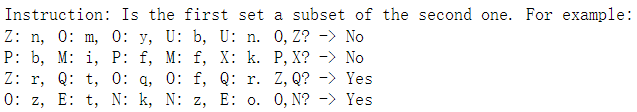

In [404]:
trainer.train() #学习率0.0001

***** Running training *****
  Num examples = 120
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 60


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,0.809391,0.800000,"['ĠYes : 0.4947', 'ĠNo : 0.4697', 'Ġyes : 0.0046']"
10,No log,0.774605,0.783333,"['ĠYes : 0.5048', 'ĠNo : 0.4587', 'Ġyes : 0.0049']"
15,No log,0.743190,0.800000,"['ĠYes : 0.5141', 'ĠNo : 0.4487', 'Ġyes : 0.0051']"
20,No log,0.714057,0.816667,"['ĠYes : 0.5212', 'ĠNo : 0.4407', 'Ġyes : 0.0054']"
25,No log,0.685518,0.850000,"['ĠYes : 0.5302', 'ĠNo : 0.4309', 'Ġyes : 0.0057']"
30,No log,0.657588,0.866667,"['ĠYes : 0.5436', 'ĠNo : 0.4169', 'Ġyes : 0.0061']"
35,0.764600,0.630037,0.883333,"['ĠYes : 0.558', 'ĠNo : 0.4022', 'Ġyes : 0.0065']"
40,0.764600,0.603737,0.883333,"['ĠYes : 0.5697', 'ĠNo : 0.3903', 'Ġyes : 0.0069']"
45,0.764600,0.578470,0.900000,"['ĠYes : 0.58', 'ĠNo : 0.38', 'Ġyes : 0.0072']"
50,0.764600,0.553258,0.866667,"['ĠYes : 0.5907', 'ĠNo : 0.3698', 'Ġyes : 0.0075']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=60, training_loss=0.6793312708536784, metrics={'train_runtime': 141.0095, 'train_samples_per_second': 1.702, 'train_steps_per_second': 0.426, 'total_flos': 237937060085760.0, 'train_loss': 0.6793312708536784, 'epoch': 2.0})

In [405]:
input_strs = [make_input_str(tasks[-6], nrows=80, ncols=(3,11,5)) for __ in range(70)]
test_dataset = CHILDDataset(input_strs[:], tokenizer)
a = trainer.predict(test_dataset) #此处新生成了测试集
print(a.metrics)

***** Running Prediction *****
  Num examples = 70
  Batch size = 1


{'test_loss': 0.495894193649292, 'test_accuracy': 0.7142857142857143, 'test_precision': ['ĠYes : 0.5537', 'ĠNo : 0.4105', 'Ġyes : 0.0056'], 'test_runtime': 9.5288, 'test_samples_per_second': 7.346, 'test_steps_per_second': 7.346}


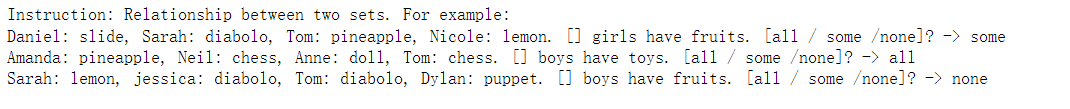

In [362]:
trainer.train()

***** Running training *****
  Num examples = 120
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 30


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,1.637403,0.150000,"['Ġall : 0.5908', 'Ġnone : 0.2102', 'Ġsome : 0.133']"
10,No log,1.306491,0.216667,"['Ġall : 0.5281', 'Ġnone : 0.2391', 'Ġsome : 0.1668']"
15,No log,1.064411,0.500000,"['Ġall : 0.4995', 'Ġnone : 0.2304', 'Ġsome : 0.2072']"
20,No log,0.791885,0.816667,"['Ġnone : 0.4746', 'Ġall : 0.3142', 'Ġsome : 0.1544']"
25,No log,0.492620,0.950000,"['Ġnone : 0.5302', 'Ġall : 0.2921', 'Ġsome : 0.132']"
30,No log,0.318130,0.950000,"['Ġnone : 0.7519', 'Ġall : 0.1234', 'Ġsome : 0.0906']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=30, training_loss=1.1609226226806642, metrics={'train_runtime': 83.9215, 'train_samples_per_second': 1.43, 'train_steps_per_second': 0.357, 'total_flos': 144461786480640.0, 'train_loss': 1.1609226226806642, 'epoch': 1.0})

In [363]:
input_strs = [make_input_str(tasks[-8], nrows=30, ncols=(4, 4, 4)) for __ in range(70)]
test_dataset = CHILDDataset(input_strs[:], tokenizer)
a = trainer.predict(test_dataset) #此处新生成了测试集
print(a.metrics)

***** Running Prediction *****
  Num examples = 70
  Batch size = 1


{'test_loss': 0.2498760223388672, 'test_accuracy': 0.9857142857142858, 'test_precision': ['Ġall : 0.6589', 'Ġsome : 0.2509', 'Ġnone : 0.0339'], 'test_runtime': 11.1032, 'test_samples_per_second': 6.305, 'test_steps_per_second': 6.305}


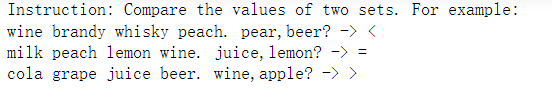

In [347]:
trainer.train()

***** Running training *****
  Num examples = 120
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 60


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,0.902350,0.716667,"['Ġ< : 0.3867', 'Ġ> : 0.3107', 'Ġ== : 0.0481']"
10,No log,0.353972,0.933333,"['Ġ< : 0.7527', 'Ġ> : 0.1587', 'Ġ>= : 0.012']"
15,No log,0.071176,0.866667,"['Ċ : 0.1904', '= : 0.0434', '> : 0.0326']"
20,No log,0.008609,0.883333,"['Ġ< : 0.9883', 'Ġ> : 0.0047', '< : 0.0023']"
25,No log,0.003806,0.950000,"['Ġ< : 0.9963', 'Ġ> : 0.0021', 'Ġ<- : 0.0005']"
30,No log,0.002230,0.966667,"['Ġ< : 0.9987', 'Ġ> : 0.0005', 'Ġ<- : 0.0002']"
35,0.450500,0.001217,0.966667,"['Ġ< : 0.9994', 'Ġ> : 0.0002', '< : 0.0001']"
40,0.450500,0.000964,0.950000,"['Ġ< : 0.9997', '< : 0.0001', 'Ġ> : 0.0001']"
45,0.450500,0.000657,0.916667,"['Ġ< : 0.9998', '< : 0.0001', 'Ġ<- : 0.0']"
50,0.450500,0.000376,0.916667,"['Ġ< : 0.9998', '< : 0.0001', 'Ġ<- : 0.0']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=60, training_loss=0.2256105103219549, metrics={'train_runtime': 66.7974, 'train_samples_per_second': 3.593, 'train_steps_per_second': 0.898, 'total_flos': 117080140677120.0, 'train_loss': 0.2256105103219549, 'epoch': 2.0})

In [348]:
input_strs = [make_input_str(tasks[-9], nrows=40, ncols=(4,2)) for __ in range(70)] #Compare the values of two sets.
test_dataset = CHILDDataset(input_strs[:], tokenizer)
a = trainer.predict(test_dataset) #此处新生成了测试集
print(a.metrics)

***** Running Prediction *****
  Num examples = 70
  Batch size = 1


{'test_loss': 0.00023217464331537485, 'test_accuracy': 0.9857142857142858, 'test_precision': ['Ġ> : 0.9995', 'Ġ= : 0.0002', 'Ġ>= : 0.0002'], 'test_runtime': 4.0984, 'test_samples_per_second': 17.08, 'test_steps_per_second': 17.08}


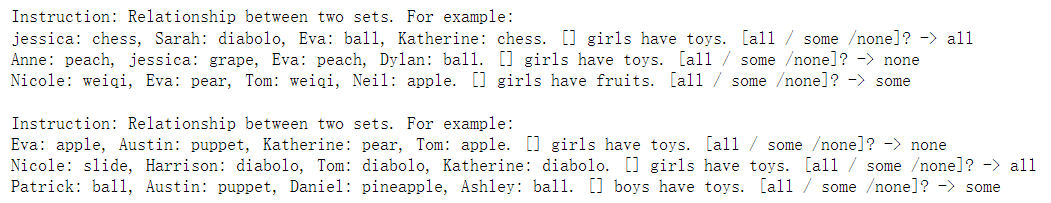

In [335]:
trainer.train() #all/none/some

***** Running training *****
  Num examples = 120
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 60


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,1.613116,0.166667,"['Ġall : 0.4213', 'Ġnone : 0.3368', 'Ġsome : 0.1252']"
10,No log,1.317356,0.366667,"['Ġall : 0.3742', 'Ġnone : 0.261', 'Ġsome : 0.2373']"
15,No log,1.019361,0.683333,"['Ġsome : 0.4355', 'Ġall : 0.3284', 'Ġnone : 0.1312']"
20,No log,0.776384,0.750000,"['Ġsome : 0.5721', 'Ġall : 0.3058', 'Ġnone : 0.0457']"
25,No log,0.506797,0.883333,"['Ġsome : 0.7429', 'Ġall : 0.2115', 'Ġnone : 0.0159']"
30,No log,0.252517,0.950000,"['Ġsome : 0.8991', 'Ġall : 0.0839', 'Ġnone : 0.0043']"
35,1.089400,0.111573,0.933333,"['Ġsome : 0.9627', 'Ġall : 0.0319', 'some : 0.0016']"
40,1.089400,0.161489,0.933333,"['Ġsome : 0.9923', 'Ġall : 0.0046', 'some : 0.002']"
45,1.089400,0.075194,0.966667,"['Ġsome : 0.9973', 'some : 0.0014', 'Ġall : 0.0005']"
50,1.089400,0.094131,0.966667,"['Ġsome : 0.9989', 'some : 0.0007', 'Ġall : 0.0001']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=60, training_loss=0.641343363126119, metrics={'train_runtime': 169.1064, 'train_samples_per_second': 1.419, 'train_steps_per_second': 0.355, 'total_flos': 294588741058560.0, 'train_loss': 0.641343363126119, 'epoch': 2.0})

In [339]:
input_strs = [make_input_str(tasks[-8], nrows=30, ncols=(4, 4, 4)) for __ in range(70)]

test_dataset = CHILDDataset(input_strs[:], tokenizer)
a = trainer.predict(test_dataset) #此处新生成了测试集
print(a.metrics)

***** Running Prediction *****
  Num examples = 70
  Batch size = 1


{'test_loss': 0.14028388261795044, 'test_accuracy': 0.9571428571428572, 'test_precision': ['Ġnone : 0.9996', 'Ġall : 0.0002', 'ĠNone : 0.0001'], 'test_runtime': 11.1119, 'test_samples_per_second': 6.3, 'test_steps_per_second': 6.3}


# 以下为1.3B

In [520]:
trainer.train() #新版大于小于

***** Running training *****
  Num examples = 600
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 150


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,2.268691,0.080000,"['Ġ< : 0.3805', 'Ġ> : 0.2963', 'Ġ= : 0.0412']"
10,No log,1.962598,0.240000,"['Ġ< : 0.3509', 'Ġ> : 0.3036', 'Ġ= : 0.0598']"
15,No log,1.715217,0.350000,"['Ġ< : 0.325', 'Ġ> : 0.3055', 'Ġ= : 0.0789']"
20,No log,1.507634,0.400000,"['Ġ< : 0.2969', 'Ġ> : 0.295', 'Ġ= : 0.1035']"
25,No log,1.325548,0.430000,"['Ġ> : 0.2705', 'Ġ< : 0.2639', 'Ġ= : 0.1376']"
30,No log,1.165320,0.475000,"['Ġ> : 0.2328', 'Ġ< : 0.2164', 'Ġ= : 0.1905']"
35,No log,1.033508,0.560000,"['Ġ= : 0.2538', 'Ġ> : 0.191', 'Ġ< : 0.1684']"
40,No log,0.914868,0.610000,"['Ġ= : 0.3069', 'Ġ== : 0.1876', 'Ġ> : 0.1575']"
45,No log,0.799914,0.710000,"['Ġ= : 0.3604', 'Ġ== : 0.2088', 'Ġ> : 0.127']"
50,No log,0.684929,0.815000,"['Ġ= : 0.42', 'Ġ== : 0.2177', 'Ġ> : 0.1013']"


***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  N

TrainOutput(global_step=150, training_loss=0.6220970662434896, metrics={'train_runtime': 2852.6965, 'train_samples_per_second': 0.21, 'train_steps_per_second': 0.053, 'total_flos': 292700351692800.0, 'train_loss': 0.6220970662434896, 'epoch': 1.0})

In [517]:
trainer.train()

***** Running training *****
  Num examples = 600
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 3000


Epoch,Training Loss,Validation Loss,Accuracy,Precision
1,0.213600,0.000075,0.905000,"['Ġ= : 1.0', 'Ġ== : 0.0', '= : 0.0']"
2,0.000000,0.000001,0.925000,"['Ġ< : 0.5669', 'Ġ= : 0.4326', 'Ġ1 : 0.0003']"
3,0.000000,0.000000,0.990000,"['Ġ= : 0.6462', 'Ġ< : 0.3528', 'Ġ1 : 0.0009']"
4,0.000000,0.000000,0.975000,"['Ġ= : 0.6907', 'Ġ< : 0.3075', 'Ġ1 : 0.0016']"
5,0.000000,0.000000,0.985000,"['Ġ= : 0.9555', 'Ġ< : 0.0418', 'Ġ1 : 0.0025']"


***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=3000, training_loss=0.04272513532016455, metrics={'train_runtime': 2321.0698, 'train_samples_per_second': 1.293, 'train_steps_per_second': 1.293, 'total_flos': 1463501758464000.0, 'train_loss': 0.04272513532016455, 'epoch': 5.0})

In [428]:
trainer.train()#RICA

***** Running training *****
  Num examples = 80
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 100


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,0.958300,0.434783,"['ĠYes : 0.6128', 'ĠNo : 0.3068', 'Ċ : 0.0132']"
10,No log,0.846871,0.521739,"['ĠYes : 0.5647', 'ĠNo : 0.3511', 'Ċ : 0.013']"
15,No log,0.735581,0.565217,"['ĠYes : 0.5048', 'ĠNo : 0.4078', 'Ċ : 0.0127']"
20,No log,0.631494,0.739130,"['ĠNo : 0.4763', 'ĠYes : 0.434', 'Ċ : 0.0122']"
25,0.871200,0.535091,0.956522,"['ĠNo : 0.5479', 'ĠYes : 0.3616', 'Ċ : 0.0114']"
30,0.871200,0.447122,1.000000,"['ĠNo : 0.6127', 'ĠYes : 0.2984', 'ĠNot : 0.0117']"
35,0.871200,0.369237,1.000000,"['ĠNo : 0.6647', 'ĠYes : 0.2502', 'ĠNot : 0.0118']"
40,0.871200,0.299188,1.000000,"['ĠNo : 0.7204', 'ĠYes : 0.1994', 'ĠNot : 0.0117']"
45,0.473100,0.241382,1.000000,"['ĠNo : 0.7807', 'ĠYes : 0.1447', 'ĠNot : 0.0116']"
50,0.473100,0.191583,1.000000,"['ĠNo : 0.8275', 'ĠYes : 0.1055', 'ĠNot : 0.0111']"


***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 23
  Batch size = 1
***** Running Evaluation *****
  Num examples = 

TrainOutput(global_step=100, training_loss=0.3295187932252884, metrics={'train_runtime': 79.0369, 'train_samples_per_second': 5.061, 'train_steps_per_second': 1.265, 'total_flos': 201428199014400.0, 'train_loss': 0.3295187932252884, 'epoch': 5.0})

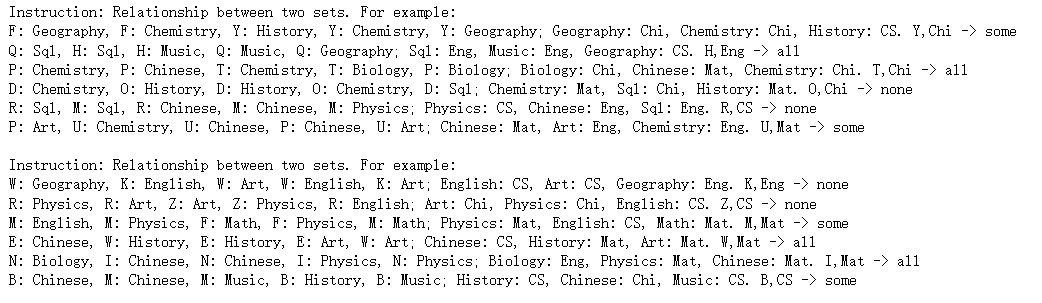

In [ ]:
Bob: apple, Emma: ball, Tom: pear, Kate: doll. [] boys have fruits. [all / some /none] -> all

In [322]:
trainer.train()#新版，下一步进行eval判断是否过拟合

***** Running training *****
  Num examples = 120
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 60


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,1.685331,0.183333,"['Ġnone : 0.409', 'Ġsome : 0.3444', 'Ġall : 0.1374']"
10,No log,1.413242,0.183333,"['Ġsome : 0.4185', 'Ġnone : 0.2715', 'Ġall : 0.1941']"
15,No log,1.134811,0.433333,"['Ġsome : 0.4374', 'Ġnone : 0.2545', 'Ġall : 0.2072']"
20,No log,0.842482,0.800000,"['Ġsome : 0.5356', 'Ġnone : 0.2035', 'Ġall : 0.188']"
25,No log,0.525855,0.950000,"['Ġsome : 0.458', 'Ġall : 0.3916', 'Ġnone : 0.0795']"
30,No log,0.346325,0.966667,"['Ġall : 0.5524', 'Ġsome : 0.3836', 'Ġnone : 0.02']"
35,1.243300,0.167787,0.966667,"['Ġall : 0.8282', 'Ġsome : 0.1313', 'Ġnone : 0.0125']"
40,1.243300,0.137759,0.966667,"['Ġall : 0.9667', 'Ġsome : 0.0233', 'Ġnone : 0.0042']"
45,1.243300,0.145786,0.966667,"['Ġall : 0.992', 'Ġsome : 0.0045', 'Ġnone : 0.0013']"
50,1.243300,0.115180,0.983333,"['Ġall : 0.999', 'Ġsome : 0.0002', 'Ġeverything : 0.0001']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=60, training_loss=0.6869547724723816, metrics={'train_runtime': 164.5481, 'train_samples_per_second': 1.459, 'train_steps_per_second': 0.365, 'total_flos': 288923572961280.0, 'train_loss': 0.6869547724723816, 'epoch': 2.0})

In [324]:
input_strs = [make_input_str(tasks[-8], nrows=30, ncols=(4, 4, 4)) for __ in range(70)]
test_dataset = CHILDDataset(input_strs[:], tokenizer)
trainer.predict(test_dataset) #此处新生成了测试集

***** Running Prediction *****
  Num examples = 70
  Batch size = 1


PredictionOutput(predictions=array([[[ -2.6154752,  -2.1349053,  -2.182977 , ..., -11.854561 ,
         -12.182815 ,  -5.645425 ],
        [ -9.893254 ,  -9.906917 ,  -6.844658 , ..., -17.660763 ,
         -19.42679  ,  -5.8024774],
        [-10.233073 ,  -6.0077457,  -9.650581 , ..., -15.504637 ,
         -12.419349 ,  -7.4766397],
        ...,
        [ -9.483704 , -12.251509 , -12.929687 , ..., -16.244257 ,
         -17.783554 , -10.627737 ],
        [ -9.7508545, -12.529946 , -13.271047 , ..., -16.3753   ,
         -18.088936 , -10.525542 ],
        [ -9.815395 , -12.724019 , -13.373404 , ..., -16.322239 ,
         -18.43342  , -10.640594 ]],

       [[ -2.6154752,  -2.1349053,  -2.182977 , ..., -11.854561 ,
         -12.182815 ,  -5.645425 ],
        [ -9.893254 ,  -9.906917 ,  -6.844658 , ..., -17.660763 ,
         -19.42679  ,  -5.8024774],
        [-10.233073 ,  -6.0077457,  -9.650581 , ..., -15.504637 ,
         -12.419349 ,  -7.4766397],
        ...,
        [ -8.081008 ,  -9

In [109]:
trainer.train() #这个好像学不会，也有可能是我的prompt初始化不好

***** Running training *****
  Num examples = 400
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 2000


Epoch,Training Loss,Validation Loss,Accuracy,Precision
1,1.128200,0.775177,0.280000,"['Ġsome : 0.7271', 'Ġall : 0.2295', 'Ġnone : 0.0367']"
2,0.772900,0.624407,0.310000,"['Ġsome : 0.6392', 'Ġall : 0.1931', 'Ġnone : 0.1492']"
3,0.686500,0.728295,0.330000,"['Ġsome : 0.838', 'Ġall : 0.1404', 'Ġnone : 0.0072']"
4,0.700800,0.664520,0.330000,"['Ġsome : 0.9705', 'Ġall : 0.0215', 'Ġmost : 0.0025']"
5,0.644700,0.683085,0.330000,"['Ġsome : 0.7134', 'Ġall : 0.265', 'Ġnone : 0.0138']"


***** Running Evaluation *****
  Num examples = 100
  Batch size = 1
***** Running Evaluation *****
  Num examples = 100
  Batch size = 1
***** Running Evaluation *****
  Num examples = 100
  Batch size = 1
***** Running Evaluation *****
  Num examples = 100
  Batch size = 1
***** Running Evaluation *****
  Num examples = 100
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2000, training_loss=0.7866153259277344, metrics={'train_runtime': 858.991, 'train_samples_per_second': 2.328, 'train_steps_per_second': 2.328, 'total_flos': 4170193182720000.0, 'train_loss': 0.7866153259277344, 'epoch': 5.0})

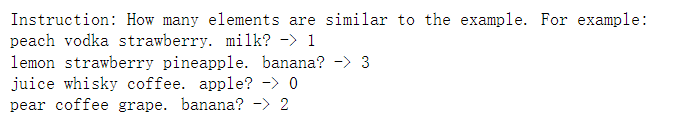 这个和后面那一个是同一个问题,我测试了不同的学习率

In [289]:
trainer.train()#How_many_elements_are_similar_to_the_example 学习率0.0001

***** Running training *****
  Num examples = 120
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 90


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,1.702919,0.183333,"['Ġ1 : 0.3931', 'Ġ0 : 0.1633', 'Ġ2 : 0.116']"
10,No log,1.629344,0.250000,"['Ġ1 : 0.4239', 'Ġ0 : 0.1463', 'Ġ4 : 0.1158']"
15,No log,1.552879,0.400000,"['Ġ1 : 0.4643', 'Ġ0 : 0.1295', 'Ġ4 : 0.1161']"
20,No log,1.476833,0.383333,"['Ġ1 : 0.5111', 'Ġ4 : 0.113', 'Ġ0 : 0.1126']"
25,No log,1.396219,0.400000,"['Ġ1 : 0.5616', 'Ġ4 : 0.108', 'Ġ0 : 0.0949']"
30,No log,1.318351,0.433333,"['Ġ1 : 0.6109', 'Ġ4 : 0.1026', 'Ġ0 : 0.0775']"
35,1.561600,1.236830,0.466667,"['Ġ1 : 0.6668', 'Ġ4 : 0.0916', 'Ġ2 : 0.0627']"
40,1.561600,1.155091,0.533333,"['Ġ1 : 0.73', 'Ġ4 : 0.0759', 'Ġ2 : 0.0509']"
45,1.561600,1.059110,0.533333,"['Ġ1 : 0.7945', 'Ġ4 : 0.0627', 'Ġ2 : 0.0378']"
50,1.561600,0.941614,0.616667,"['Ġ1 : 0.8576', 'Ġ4 : 0.0503', 'Ġ5 : 0.0265']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 

TrainOutput(global_step=90, training_loss=1.0907849205864801, metrics={'train_runtime': 99.8499, 'train_samples_per_second': 3.605, 'train_steps_per_second': 0.901, 'total_flos': 169955042918400.0, 'train_loss': 1.0907849205864801, 'epoch': 3.0})

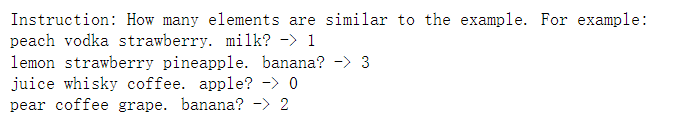

In [303]:
trainer.train()#How_many_elements_are_similar_to_the_example 学习率0.001

***** Running training *****
  Num examples = 800
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 600


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,1.324453,0.605000,"['Ġ1 : 0.4708', 'Ġ0 : 0.1742', 'Ġ3 : 0.1074']"
10,No log,0.836421,0.715000,"['Ġ1 : 0.9614', 'Ġ5 : 0.0082', 'Ġ0 : 0.0077']"
15,No log,0.648392,0.185000,"['Ġ1 : 0.9959', '1 : 0.0034', 'Ġ5 : 0.0004']"
20,No log,0.241184,0.615000,"['Ġ1 : 0.9981', '1 : 0.0017', 'Ġ5 : 0.0001']"
25,No log,0.078094,0.780000,"['Ġ1 : 0.9993', '1 : 0.0007', 'Ġ0 : 0.0']"
30,No log,0.014560,0.925000,"['Ġ1 : 0.9996', '1 : 0.0004', 'Ġ5 : 0.0']"
35,No log,0.002897,0.990000,"['Ġ1 : 0.9999', '1 : 0.0001', 'Ġ0 : 0.0']"
40,No log,0.001040,1.000000,"['Ġ1 : 0.9999', '1 : 0.0001', 'Ġ0 : 0.0']"
45,No log,0.000812,1.000000,"['Ġ1 : 0.9999', '1 : 0.0001', 'Ġ0 : 0.0']"
50,No log,0.000737,1.000000,"['Ġ1 : 0.9999', '1 : 0.0001', 'Ġ5 : 0.0']"


***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
***** Running Evaluation *****
  N

KeyboardInterrupt: 

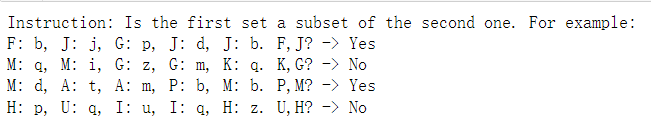

In [126]:
trainer.train()#Is the first set a subset of the second one

***** Running training *****
  Num examples = 120
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 60


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,0.565851,0.933333,"['ĠYes : 0.5505', 'ĠNo : 0.4105', 'ĠNot : 0.0036']"
10,No log,0.427244,0.966667,"['ĠYes : 0.551', 'ĠNo : 0.4137', 'ĠNot : 0.0032']"
15,No log,0.246184,1.000000,"['ĠNo : 0.6102', 'ĠYes : 0.3537', 'ĠNot : 0.0041']"
20,No log,0.077912,1.000000,"['ĠNo : 0.9029', 'ĠYes : 0.0698', 'ĠNO : 0.0059']"
25,No log,0.008714,1.000000,"['ĠNo : 0.972', 'ĠYes : 0.026', 'No : 0.0011']"
30,No log,0.001941,1.000000,"['ĠNo : 0.9972', 'ĠYes : 0.002', 'No : 0.0006']"
35,0.309400,0.001298,1.000000,"['ĠNo : 0.9983', 'ĠYes : 0.0011', 'No : 0.0006']"
40,0.309400,0.000944,1.000000,"['ĠNo : 0.9984', 'ĠYes : 0.0012', 'No : 0.0004']"
45,0.309400,0.000580,1.000000,"['ĠNo : 0.9986', 'ĠYes : 0.0011', 'No : 0.0003']"
50,0.309400,0.000306,1.000000,"['ĠNo : 0.9995', 'ĠYes : 0.0002', 'No : 0.0002']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=60, training_loss=0.15495672843729455, metrics={'train_runtime': 140.4687, 'train_samples_per_second': 1.709, 'train_steps_per_second': 0.427, 'total_flos': 237937060085760.0, 'train_loss': 0.15495672843729455, 'epoch': 2.0})

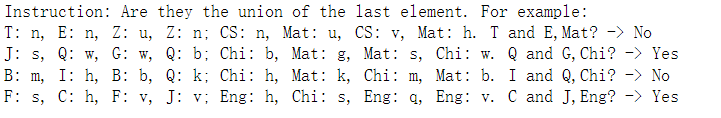

In [87]:
trainer.train()#Are_they_the_union_of_the_last_element

***** Running training *****
  Num examples = 120
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 60


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,0.630359,0.800000,"['ĠYes : 0.6843', 'ĠNo : 0.2877', 'Ġyes : 0.0033']"
10,No log,0.454428,0.950000,"['ĠYes : 0.6684', 'ĠNo : 0.3023', 'Ġyes : 0.0027']"
15,No log,0.305781,0.983333,"['ĠYes : 0.7961', 'ĠNo : 0.18', 'Ġyes : 0.0034']"
20,No log,0.227064,1.000000,"['ĠYes : 0.8607', 'ĠNo : 0.1187', 'Ġyes : 0.0024']"
25,No log,0.111653,1.000000,"['ĠYes : 0.9648', 'ĠNo : 0.0263', 'Ġyes : 0.0019']"
30,No log,0.041396,1.000000,"['ĠYes : 0.9943', 'ĠNo : 0.0018', 'Ġyes : 0.0013']"
35,0.393600,0.014563,1.000000,"['ĠYes : 0.998', 'Yes : 0.0007', 'Ġyes : 0.0007']"
40,0.393600,0.006093,1.000000,"['ĠYes : 0.9993', 'Yes : 0.0003', 'Ġyes : 0.0002']"
45,0.393600,0.003678,1.000000,"['ĠYes : 0.9997', 'Yes : 0.0001', 'Ġyes : 0.0001']"
50,0.393600,0.001994,1.000000,"['ĠYes : 0.9999', 'Ġyes : 0.0001', 'Yes : 0.0001']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=60, training_loss=0.20048423732320467, metrics={'train_runtime': 182.4739, 'train_samples_per_second': 1.315, 'train_steps_per_second': 0.329, 'total_flos': 360682368860160.0, 'train_loss': 0.20048423732320467, 'epoch': 2.0})

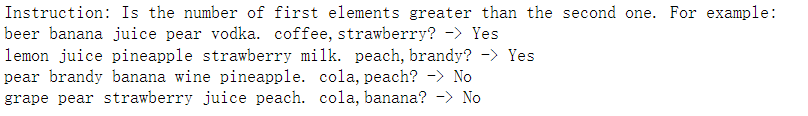

In [701]:
trainer.train() #Is_the_number_of_first_elements_greater_than_the_second_one

***** Running training *****
  Num examples = 120
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 60


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,0.534460,0.800000,"['ĠYes : 0.8505', 'ĠNo : 0.1164', 'Ġyes : 0.0118']"
10,No log,0.362796,0.966667,"['ĠYes : 0.796', 'ĠNo : 0.164', 'Ġyes : 0.0129']"
15,No log,0.122334,1.000000,"['ĠYes : 0.7715', 'ĠNo : 0.1456', 'Ġyes : 0.0164']"
20,No log,0.017721,1.000000,"['ĠYes : 0.9533', 'ĠYES : 0.0252', 'ĠCorrect : 0.0054']"
25,No log,0.007206,1.000000,"['ĠYes : 0.9908', 'ĠYES : 0.0045', 'Ġyes : 0.0022']"
30,No log,0.004869,1.000000,"['ĠYes : 0.9967', 'ĠYES : 0.0012', 'Ġyes : 0.0011']"
35,0.231300,0.002163,1.000000,"['ĠYes : 0.9985', 'ĠYES : 0.0008', 'Ġyes : 0.0004']"
40,0.231300,0.000982,1.000000,"['ĠYes : 0.9991', 'ĠYES : 0.0006', 'Ġyes : 0.0002']"
45,0.231300,0.000617,1.000000,"['ĠYes : 0.9994', 'ĠYES : 0.0004', 'Ġyes : 0.0001']"
50,0.231300,0.000431,1.000000,"['ĠYes : 0.9995', 'ĠYES : 0.0003', 'Ġyes : 0.0001']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=60, training_loss=0.11609306757648787, metrics={'train_runtime': 126.1428, 'train_samples_per_second': 1.903, 'train_steps_per_second': 0.476, 'total_flos': 160513096089600.0, 'train_loss': 0.11609306757648787, 'epoch': 2.0})

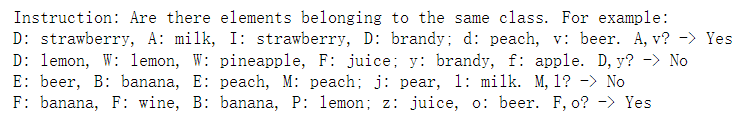

In [583]:
trainer.train() #Are_there_elements_belonging_to_the_same_class

***** Running training *****
  Num examples = 120
  Num Epochs = 4
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 120


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,0.657310,0.716667,"['ĠYes : 0.5609', 'ĠNo : 0.3697', 'Ġyes : 0.0115']"
10,No log,0.522732,0.816667,"['ĠYes : 0.6058', 'ĠNo : 0.3322', 'Ġyes : 0.0115']"
15,No log,0.372633,0.933333,"['ĠYes : 0.6927', 'ĠNo : 0.2519', 'Ġyes : 0.0138']"
20,No log,0.162410,1.000000,"['ĠYes : 0.7421', 'ĠNo : 0.1301', 'Ġyes : 0.0298']"
25,No log,0.044629,1.000000,"['ĠYes : 0.8988', 'ĠCorrect : 0.0194', 'Ġyes : 0.0164']"
30,No log,0.008334,1.000000,"['ĠYes : 0.9599', 'YES : 0.0099', 'ĠYES : 0.0075']"
35,0.373800,0.003780,1.000000,"['ĠYes : 0.9918', 'YES : 0.0028', 'Ġyes : 0.0021']"
40,0.373800,0.001884,1.000000,"['ĠYes : 0.9891', 'ĠYES : 0.0026', 'Ġyes : 0.0022']"
45,0.373800,0.001950,1.000000,"['ĠYes : 0.9783', 'ĠYES : 0.0056', 'ĠCorrect : 0.0051']"
50,0.373800,0.001387,1.000000,"['ĠYes : 0.9822', 'ĠCorrect : 0.0047', 'ĠYES : 0.0044']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 

TrainOutput(global_step=120, training_loss=0.09400786680247014, metrics={'train_runtime': 345.9893, 'train_samples_per_second': 1.387, 'train_steps_per_second': 0.347, 'total_flos': 558963252264960.0, 'train_loss': 0.09400786680247014, 'epoch': 4.0})

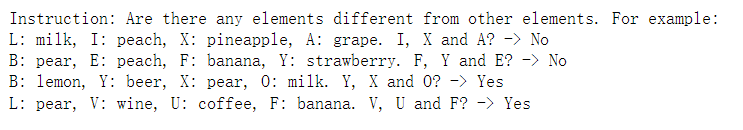

In [558]:
trainer.train() # Are there any elements different from other elements

***** Running training *****
  Num examples = 120
  Num Epochs = 4
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 120


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,0.544517,0.866667,"['ĠYes : 0.6329', 'ĠNo : 0.3283', 'Ġyes : 0.0081']"
10,No log,0.374620,0.966667,"['ĠYes : 0.4946', 'ĠNo : 0.4608', 'Ġyes : 0.0064']"
15,No log,0.220799,1.000000,"['ĠNo : 0.6041', 'ĠYes : 0.3498', 'ĠNot : 0.0074']"
20,No log,0.137133,1.000000,"['ĠNo : 0.6921', 'ĠYes : 0.2828', 'ĠNot : 0.005']"
25,No log,0.051933,1.000000,"['ĠNo : 0.9036', 'ĠYes : 0.0765', 'ĠNot : 0.0047']"
30,No log,0.027002,1.000000,"['ĠNo : 0.9828', 'ĠYes : 0.009', 'ĠNot : 0.0019']"
35,0.297800,0.010745,1.000000,"['ĠNo : 0.9959', 'ĠYes : 0.0021', 'ĠNO : 0.0004']"
40,0.297800,0.005314,1.000000,"['ĠNo : 0.9985', 'ĠYes : 0.0004', 'No : 0.0003']"
45,0.297800,0.002164,1.000000,"['ĠNo : 0.9975', 'ĠYes : 0.002', 'No : 0.0002']"
50,0.297800,0.000907,1.000000,"['ĠNo : 0.9994', 'ĠYes : 0.0004', 'No : 0.0002']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 

TrainOutput(global_step=120, training_loss=0.07609481129911728, metrics={'train_runtime': 285.0569, 'train_samples_per_second': 1.684, 'train_steps_per_second': 0.421, 'total_flos': 460767005245440.0, 'train_loss': 0.07609481129911728, 'epoch': 4.0})

# 到这为止,肖老师

In [369]:
trainer.train()  #Is the intersection of two sets empty

***** Running training *****
  Num examples = 120
  Num Epochs = 4
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 120


Step,Training Loss,Validation Loss,Accuracy,Precision
5,No log,0.628385,0.766667,"['ĠNo : 0.6177', 'ĠYes : 0.3371', 'ĠNot : 0.0044']"
10,No log,0.493046,0.816667,"['ĠNo : 0.7238', 'ĠYes : 0.2425', 'ĠNot : 0.0032']"
15,No log,0.325506,1.000000,"['ĠNo : 0.8506', 'ĠYes : 0.1233', 'ĠNot : 0.0029']"
20,No log,0.178578,1.000000,"['ĠNo : 0.9265', 'ĠYes : 0.058', 'ĠNot : 0.0018']"
25,No log,0.043850,1.000000,"['ĠNo : 0.9722', 'ĠYes : 0.0222', 'No : 0.0011']"
30,No log,0.009887,1.000000,"['ĠNo : 0.9972', 'ĠYes : 0.0014', 'No : 0.001']"
35,0.356400,0.003472,1.000000,"['ĠNo : 0.9985', 'No : 0.001', 'ĠYes : 0.0004']"
40,0.356400,0.001365,1.000000,"['ĠNo : 0.9991', 'No : 0.0008', 'ĠYes : 0.0001']"
45,0.356400,0.000747,1.000000,"['ĠNo : 0.9995', 'No : 0.0005', 'ĠYes : 0.0']"
50,0.356400,0.000489,1.000000,"['ĠNo : 0.9997', 'No : 0.0003', 'ĠYes : 0.0']"


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 60
  Batch size = 1
***** Running Evaluation *****
  Num examples = 

TrainOutput(global_step=120, training_loss=0.08959315906201179, metrics={'train_runtime': 291.8731, 'train_samples_per_second': 1.645, 'train_steps_per_second': 0.411, 'total_flos': 464543783976960.0, 'train_loss': 0.08959315906201179, 'epoch': 4.0})

In [142]:
# for s in sample(input_strss, 2): print(s)

In [245]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_data,compute_metrics=compute_metrics,
                  optimizers=(create_optimizer(model, training_args), None))

/nas/xd/projects/transformers/src/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [143]:
# trainer.predict(test_dataset)
# print(metic.predictions.shape)
# print(metic.label_ids.shape)

In [62]:
trainer.evaluate() #没有训练的

***** Running Evaluation *****
  Num examples = 200
  Batch size = 1


{'eval_loss': 0.8268557786941528,
 'eval_accuracy': 0.465,
 'eval_runtime': 46.7481,
 'eval_samples_per_second': 4.278,
 'eval_steps_per_second': 4.278}

In [144]:
# trainer.train()

In [145]:
# trainer.evaluate()

In [146]:
# trainer.train()

In [147]:
# trainer.train()

In [148]:
# predictions = trainer.predict(eval_dataset)
# print(predictions)

In [149]:
# print(predictions.predictions.shape)

In [117]:
predictions = trainer.predict(train_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

***** Running Prediction *****
  Num examples = 40
  Batch size = 1


(40, 149, 50257) (40, 149)


In [150]:
# preds1 = predictions.label_ids
# preds2 = predictions.predictions
# print(preds1,preds2)

In [151]:
# trainer.train()
#

In [152]:
# trainer.train()

In [153]:
# trainer.evaluate()

In [154]:
# trainer.train()

In [81]:
trainer.place_model_on_device

True

In [82]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [83]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [85]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])

index,value
0,A
1,B
2,C
3,B


['C']

['b']

[2]

['C', 'A', 'B', 'B']

['B', 'B', 'C', 'A']

index,value
0,A
1,A
2,C
3,B


False

['A', 'B', 'B', 'C', 'C']

[1, 1, 2, 1, 2, 3]

['B']

['B']